Goal of this tutorial is to showcase how to retrieve information from PDF papers, including both images and textual information.

1. The user need to upload a PDF file or use the provided exemplar PDF file located inside the "pdf_example" folder.
2. Each page of the PDF file is converted to an image and the images and textual information is extracted and save in an output folder.
3. The extracted data will be stored to a vector database (ChromaDB).

The agent will provide literature informed answers to human questions based on the retrieved data.

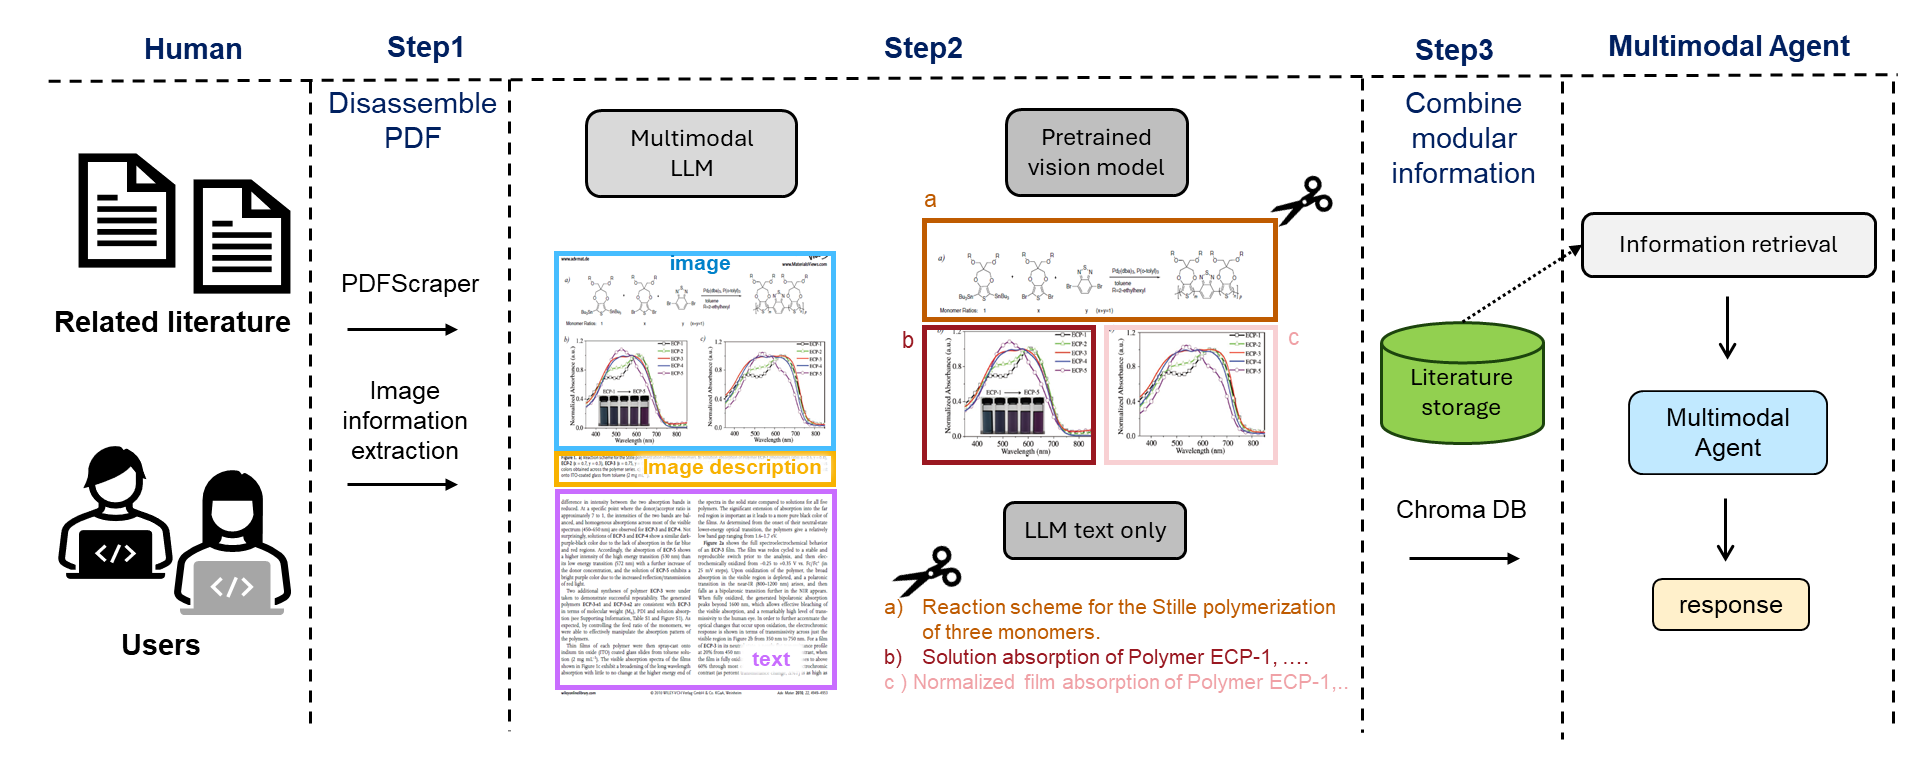

# Initialization

In [ ]:
# Clone the repository
!git clone https://github.com/katerinavr/MatAGen.git
%cd MatAGen

In [ ]:
# Install the dependencies
!pip install .

# Clear output
from IPython.display import clear_output
clear_output()

We also need to download the pretrained weights of the YOLO model for image cropping



In [4]:
# load pretrained vision model weights
import os
os.makedirs("/usr/local/lib/python3.11/checkpoints", exist_ok=True )
!gdown 1baAJd8WDN55usWSn8YEgQ9fij72A8mzI -O /usr/local/lib/python3.11/checkpoints/yolov11_finetuned_augmentation_best.pt

Downloading...
From (original): https://drive.google.com/uc?id=1baAJd8WDN55usWSn8YEgQ9fij72A8mzI
From (redirected): https://drive.google.com/uc?id=1baAJd8WDN55usWSn8YEgQ9fij72A8mzI&confirm=t&uuid=ccdf0646-9f3b-469f-b224-67d3cad5b10c
To: /usr/local/lib/python3.11/checkpoints/yolov11_finetuned_augmentation_best.pt
100% 114M/114M [00:00<00:00, 144MB/s]


To be able to run the tutorial you need to have and OPENAI API key

In [34]:
OPENAI_API_KEY = "" # Your OpenAI API key

In [11]:
from matagen.agents import *
from matagen.scraping.pdf_scraper import pdf_scraper_tool
import chromadb
import os
import pprint
from PIL import Image
from IPython.display import display, Markdown

In [12]:
pdf_file_path = "pdf_example"
output_base_dir = "outputs"
pdf_scraper_tool(pdf_file_path, output_base_dir, paper_name="pdf_papers", api_key = OPENAI_API_KEY)

self.results_directory_tool outputs/pdf_papers
self.results_directory_tool outputs/pdf_papers
self.results_directory_tool outputs/pdf_papers
Running PDF Scraper
articles ['pdf_example/4T-PEO4.pdf']
>>> (1 of 1) Extracting figures from: 4T-PEO4.pdfProcessing page 1
Found 0 images on page 1
No images with positions found on page 1
Processing page 2
Found 1 images on page 2
Converting grayscale image xref 14 to RGB
Saved image page_2_img_1.png
Processing page 3
Found 1 images on page 3
Converting image xref 29 from colorspace DeviceCMYK to RGB
Saved image page_3_img_1.png
Processing page 4
Found 1 images on page 4
Converting grayscale image xref 41 to RGB
Saved image page_4_img_1.png
Processing page 5
Found 1 images on page 5
Converting image xref 47 from colorspace DeviceCMYK to RGB
Saved image page_5_img_1.png
Processing page 6
Found 1 images on page 6
Converting image xref 60 from colorspace DeviceCMYK to RGB
Saved image page_6_img_1.png
Processing page 7
Found 1 images on page 7
Conve

{'page_2_img_1.png': {'title': 'Self‐Assembly Behavior of an Oligothiophene‐Based Conjugated Liquid Crystal and Its Implication for Ionic Conductivity Characteristics',
  'article_name': 'pdf_example/4T-PEO4',
  'image_url': [],
  'figure_name': 'page_2_img_1.png',
  'full_caption': 'Scheme 1. Synthetic procedure of 4T/PEO4.',
  'figure_path': 'output/figures/page_2_img_1.png',
  'master_images': [{'classification': 'subfigure',
    'confidence': 1.0,
    'height': 782,
    'width': 2333,
    'geometry': [{'x': 0, 'y': 0},
     {'x': 2333, 'y': 0},
     {'x': 0, 'y': 782},
     {'x': 2333, 'y': 782}],
    'subfigure_label': {'text': '0',
     'geometry': [{'x': 0, 'y': 0},
      {'x': 2333, 'y': 0},
      {'x': 0, 'y': 782},
      {'x': 2333, 'y': 782}]},
    'caption': [],
    'keywords': []}],
  'article_url': [],
  'license': [],
  'open': [],
  'unassigned': {'master_images': [],
   'dependent_images': [],
   'inset_images': [],
   'subfigure_labels': [],
   'scale_bar_labels': [],

      Expected output in the "retrieved_image_caption.json" file
    {
      "full_caption": "Figure 1. DSC traces (10 °C min−1) and POM images of 4T/PEO4-LiTFSI complexes: a) first cooling scans (indicated by black arrows) and second subsequent heating scans (indicated by red arrows) of 4T/PEO-LiTFSI complexes (r = 0, r = 0.01, r = 0.05). b,c) POM image of pristine 4T/PEO4 (r = 0) on cooling from isotropic melt at 95 and 60 °C. d,e) POM image of 4T/PEO4-LiTFSI complex (r = 0.01) on cooling from isotropic melt at 75 and 40 °C, and f,g) POM image of 4T/PEO4-LiTFSI complex (r = 0.05) on cooling from isotropic melt at 97 and 50 °C (scale bar: 100 μm).",
      "caption": "POM image of 4T/PEO4-LiTFSI complex (r = 0.05) on cooling from isotropic melt at 97 and 50 °C.",
      "caption_summary": [
        "POM",
        "4T/PEO4-LiTFSI",
        "cooling"
      ],
      "image": "outputs/pdf_papers/images_folder/page_3_img_1_f.jpg",
      "article_name": "pdf_example/4T-PEO4"
    }

*   Now all the data are organized in the "outputs"folder

*   We will further use these data to populate a vector database (ChromaDB) that can be used for multimodal RAG




In [ ]:
# Load the sentence transformer

from chromadb.utils import embedding_functions

embedding_functions.SentenceTransformerEmbeddingFunction("all-MiniLM-L6-v2")

In [14]:
# Use the multimodal information to create a RAG Agent
from matagen.analysis import multimodal_db

outputs_folder = "outputs/pdf_papers"
json_file_name = "retrieved_image_caption_pairs.json"  # Name of the JSON file inside OUTPUTS_FOLDER
text_folder_name = "pdf"      # Name of the subfolder with the retrieved text from the PDF file
chroma_db_path = "./my_multimodal_chroma_db" # Directory to store the persistent ChromaDB database
collection_name = "multimodal_rag_collection" # Name for the ChromaDB collection
text_embedding_model = "all-MiniLM-L6-v2" # Standard good default
notebook_dir = os.getcwd()
DB_DIR_PATH = os.path.abspath(os.path.join(notebook_dir, chroma_db_path))
PROJECT_ROOT = os.path.dirname(DB_DIR_PATH) # Assume DB path is relative to project root

multimodal_db.create_multimodal_chromadb(outputs_folder, json_file_name, text_folder_name, chroma_db_path, collection_name, text_embedding_model)

Starting ChromaDB Population (Text Chunks + Image Captions)
Script directory: /content/MatAGen
Resolved paths:
  Outputs folder: outputs/pdf_papers
  JSON file path: outputs/pdf_papers/retrieved_image_caption_pairs.json
  Text folder path: outputs/pdf_papers/pdf
  ChromaDB storage path: /content/MatAGen/./my_multimodal_chroma_db

--- Loading Source Data ---
Successfully loaded 30 image records from outputs/pdf_papers/retrieved_image_caption_pairs.json
Finished finding 1 text files.
Finished chunking 1 text files.

--- Preparing Documents from Image Captions (30 records) ---
Finished preparing 30 documents from image captions.

--- Initializing ChromaDB ---
Using persistent storage at: /content/MatAGen/./my_multimodal_chroma_db

Setting up TEXT embedding function: all-MiniLM-L6-v2
Text embedding function ready.

Accessing collection: 'multimodal_rag_collection'
DEBUG: Embedding function being used: <chromadb.utils.embedding_functions.sentence_transformer_embedding_function.SentenceTrans

In [7]:
import chromadb

# Connect to ChromaDB
print(f"Attempting to connect to ChromaDB at: {chroma_db_path}")
try:
    client = chromadb.PersistentClient(path=chroma_db_path)
    print("Successfully connected to ChromaDB.")

    print(f"Accessing collection: '{collection_name}'")
    collection = client.get_collection(name=collection_name)
    print(f"Successfully accessed collection. Contains approx. {collection.count()} items.")
    db_ready = True
except Exception as e:
    print(f"Error connecting to DB or getting collection: {e}")
    print("Please ensure the path and collection name are correct and the DB exists.")
    db_ready = False

Attempting to connect to ChromaDB at: ./my_multimodal_chroma_db
Successfully connected to ChromaDB.
Accessing collection: 'multimodal_rag_collection'
Successfully accessed collection. Contains approx. 99 items.


In [44]:
!rm -r /content/MatAGen/.cache

In [63]:
# You can try the following user queries to retrieve related images from the database
user_query = "Explain the POM image of 4T/PEO4-LiTFSI complex with ratio = 0.05 and at 50 Celsius"
# user_query = "What is the sphericity of PEO4 chains from simulation"

In [64]:
# RAG : Retrieve documents
N_RESULTS_RAG = 20

if db_ready:
    print(f"\nSearching for '{user_query}' (retrieving {N_RESULTS_RAG} results for RAG context)...")
    try:
        results = collection.query(
            query_texts=[user_query],
            n_results=N_RESULTS_RAG, # Use the larger N value
            include=['metadatas', 'documents', 'distances']
        )
        query_done = True
        if not results or not results.get('ids') or not results['ids'][0]:
             print("No documents found for the query.")
             query_done = False

    except Exception as e:
        print(f"An error occurred during querying: {e}")
        query_done = False
else:
    print("Cannot query, DB not ready.")
    query_done = False


Searching for 'Explain the POM image of 4T/PEO4-LiTFSI complex with ratio = 0.05 and at 50 Celsius' (retrieving 20 results for RAG context)...


--- ### RAG Analysis for Query: 'Explain the POM image of 4T/PEO4-LiTFSI complex with ratio = 0.05 and at 50 Celsius' ---


Processing retrieved documents to find best image match and build context...


--- ### Assembled Context for LLM ---

```
[Source Doc ID: imgcap_5_0df6ddec-107d-425f-a91b-ecba598d76d6, Type: image_caption]
POM image of 4T/PEO4-LiTFSI complex (r = 0.05) on cooling from isotropic melt at 97 and 50 °C (scale bar: 100 μm).

---
[Source Doc ID: imgcap_3_77c52583-cf94-4686-be6f-5e28e7f6580c, Type: image_caption]
POM image of 4T/PEO4-LiTFSI complex (r = 0.01) on cooling from isotropic melt at 75 and 40 °C.

---
[Source Doc ID: imgcap_7_42ae458d-2bab-49a8-a052-5a8bc36e3a25, Type: image_caption]
POM image of 4T/PEO4-LiTFSI complex (r = 0.01) on cooling from isotropic melt at 75 and 40 °C.

---
[Source Doc ID: imgcap_1_08a0a9a9-aa06-4a37-9d68-c46a6e378428, Type: image_caption]
POM image of 4T/PEO4-LiTFSI complex (r = 0.05) on cooling from isotropic melt at 97 and 50 °C.

---
[Source Doc ID: imgcap_4_850d2916-acb0-49ea-9d6e-9cc3c268ac80, Type: image_caption]
First cooling scans (indicated by black arrows) and second subsequent heating scans (indicated by red arrows) of 4T/PEO-LiTFSI complexes (r = 0, r = 0.01, r = 0.05).

---
[Source Doc ID: imgcap_13_3039557d-9e72-4252-a7ec-e26b36b20a08, Type: image_caption]
Thin film of 4T/PEO4-LiTFSI complex (r = 0.01) at (d) 25 °C (as-cast)

---
[Source Doc ID: text_4T-PEO4.txt_15_2c4caa6f-f7ee-4475-885f-bc47726a8978, Type: text_chunk]
s have overlapped, consistent with DSC meas-
urement. As temperature further decreases, the batonnet tex-
ture fades while the other more ordered phase becomes the 
majority at ambient temperature (see Figure 1e). The complex 
with r = 0.05 shows a similar trend to the one with r = 0.01. An 
obvious batonnet texture at the isotropic–smectic transition was 
observed as shown in Figure  1f, which then also experiences 
Adv. Funct. Mater. 2019, 29, 1805220
Figure 1.  DSC traces (10 °C min−1) and POM images of 4T/PEO4-LiTFSI complexes: a) first cooling scans (indicated by black arrows) and second 
subsequent heating scans (indicated by red arrows) of 4T/PEO-LiTFSI complexes (r = 0, r = 0.01, r = 0.05), b,c) POM image of pristine 4T...
```

--- ### Most Relevant Identified Image ---

Found best image match: ID imgcap_5_0df6ddec-107d-425f-a91b-ecba598d76d6 (Distance: 0.1540)


**Displaying Image:** `outputs/pdf_papers/images_folder/page_3_img_1_g.jpg`

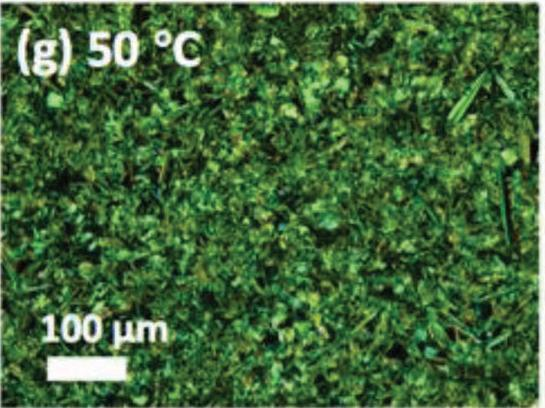

**Caption used for Embedding:** `POM image of 4T/PEO4-LiTFSI complex (r = 0.05) on cooling from isotropic melt at 97 and 50 °C (scale bar: 100 μm).`

--- ### End of Analysis ---

In [65]:
# Identify Image, Assemble Context, and Display

if db_ready and query_done:
    display(Markdown(f"--- ### RAG Analysis for Query: '{user_query}' ---"))

    # Unpack results
    ids = results.get('ids', [[]])[0]
    distances = results.get('distances', [[]])[0]
    metadatas = results.get('metadatas', [[]])[0]
    documents = results.get('documents', [[]])[0]

    # Identify best matching image caption
    best_image_match = None # Store info about the best image match found
    min_image_distance = float('inf')

    retrieved_context_list = [] # Store text content for context

    print("\nProcessing retrieved documents to find best image match and build context...")
    for i, item_id in enumerate(ids):
        metadata = metadatas[i] if metadatas and i < len(metadatas) else {}
        document = documents[i] if documents and i < len(documents) else ""
        distance = distances[i]
        doc_type = metadata.get('type', 'unknown')

        retrieved_context_list.append(f"[Source Doc ID: {item_id}, Type: {doc_type}]\n{document}\n")
        if doc_type == 'image_caption':
            if distance < min_image_distance:
                min_image_distance = distance
                relative_image_path = metadata.get('original_uri', None)
                if relative_image_path:
                    abs_image_path = os.path.abspath(os.path.join(PROJECT_ROOT, os.path.normpath(relative_image_path)))
                    if os.path.exists(abs_image_path):
                         best_image_match = {
                             "id": item_id,
                             "distance": distance,
                             "caption": document,
                             "path": abs_image_path,
                             "relative_path": relative_image_path
                         }
                    else:
                         print(f"  > Found image caption (ID: {item_id}), but image file not found at {abs_image_path}")
                         if best_image_match is None:
                              best_image_match = {"id": item_id, "distance": distance, "caption": document, "path": None, "relative_path": relative_image_path}

    context_string = "\n---\n".join(retrieved_context_list)
    display(Markdown("--- ### Assembled Context for LLM ---"))
    max_context_display_len = 2000
    display(Markdown(f"```\n{context_string[:max_context_display_len]}{'...' if len(context_string) > max_context_display_len else ''}\n```"))

    # Display identified image
    display(Markdown(f"--- ### Most Relevant Identified Image ---"))
    if best_image_match:
        print(f"Found best image match: ID {best_image_match['id']} (Distance: {best_image_match['distance']:.4f})")
        if best_image_match['path']:
            display(Markdown(f"**Displaying Image:** `{best_image_match['relative_path']}`"))
            try:
                img = Image.open(best_image_match['path'])
                # img.thumbnail((500, 500)) # Optional resize
                display(img)
            except Exception as img_e:
                print(f"    Error loading image {best_image_match['path']}: {img_e}")
        else:
            display(Markdown(f"*(Image file associated with best match (ID: {best_image_match['id']}) was not found at expected path)*"))
        display(Markdown(f"**Caption used for Embedding:** `{best_image_match['caption']}`"))

    else:
        display(Markdown("No relevant image caption document was found among the top retrieved results."))

    display(Markdown("--- ### End of Analysis ---"))

else:
    if db_ready and not query_done:
        display(Markdown("Query execution failed. Cannot display results."))
    elif not db_ready:
         display(Markdown("Cannot display results, DB not ready."))

After the information is retrieved from ChromaDB, the extracted information is passed to a multimodal agent as user prompt, retrieved context and retrieved image. The agent is stucturing a concise reply based on these inputs.

In [66]:
# You can print the most relevant image retrieved from your query
best_image_match

{'id': 'imgcap_5_0df6ddec-107d-425f-a91b-ecba598d76d6',
 'distance': 0.15395599603652954,
 'caption': 'POM image of 4T/PEO4-LiTFSI complex (r = 0.05) on cooling from isotropic melt at 97 and 50 °C (scale bar: 100 μm).',
 'path': '/content/MatAGen/outputs/pdf_papers/images_folder/page_3_img_1_g.jpg',
 'relative_path': 'outputs/pdf_papers/images_folder/page_3_img_1_g.jpg'}

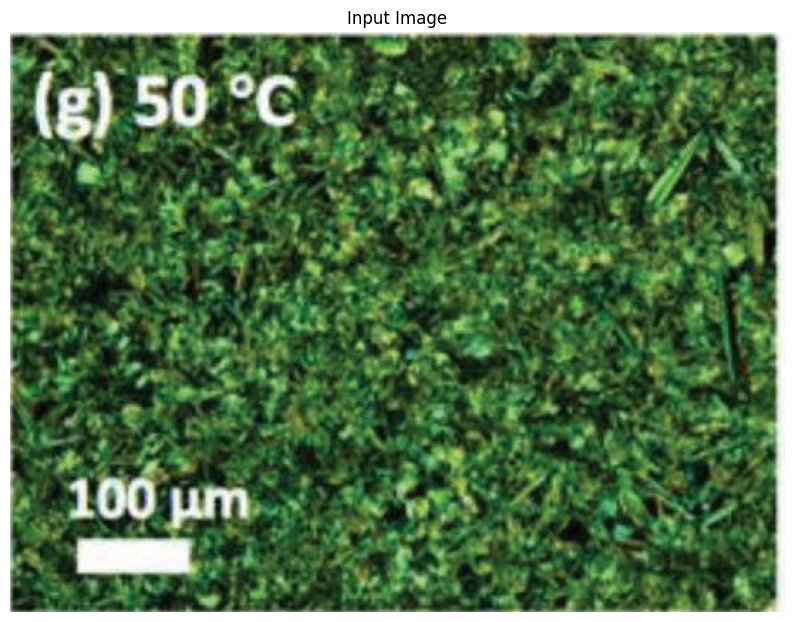


>>>>>>>> USING AUTO REPLY...

>>>>>>>> TERMINATING RUN (dd15ed7d-e478-4082-9cb3-1351de61aaea): Maximum turns (1) reached
The POM (Polarized Optical Microscopy) image of the 4T/PEO4-LiTFSI complex with a ratio of 0.05 at 50°C shows the material's texture as it cools from an isotropic melt. This specific complex is a blend of 4T (oligothiophene) and PEO4 (polyethylene oxide) with LiTFSI (lithium bis(trifluoromethanesulfonyl)imide) as a dopant.

### Key Observations:

1. **Texture and Phase Transition:**
   - At 50°C, the image reveals a complex texture indicating a transition from an isotropic to a more ordered phase. This is consistent with the behavior observed in similar complexes where a batonnet texture appears at the isotropic-smectic transition.
   - As the temperature decreases, the complex transitions to a more ordered phase, which is less pronounced compared to lower doping ratios (e.g., r = 0.01).

2. **Impact of Doping Ratio:**
   - The higher doping ratio (r = 0.05) slightl

In [70]:
from matagen.agents.multimodal_rag_agent import create_multimodal_agent

# Create the agent
multi_agent = create_multimodal_agent(
    openai_api_key=OPENAI_API_KEY, human_input_mode="ALWAYS"
)

# Determine image path
if best_image_match:
    image_path = best_image_match['relative_path']
else:
    image_path = None

# Run multimodal RAG
response = multi_agent.multimodal_rag(
    image_path=image_path,
    query=user_query,
    context=retrieved_context_list
)

print(response)